In [1]:
import sys
import os
from pathlib import Path
import math
import awkward as ak
import numpy as np
import uproot
import boost_histogram as bh
import hist
from hist import Hist, intervals, axis
import matplotlib.pyplot as plt
from matplotlib import cycler
import mplhep as hep
from coffea import nanoevents, lookup_tools
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.nanoevents.methods import vector, candidate, nanoaod
from coffea.nanoevents.methods.vector import PtEtaPhiELorentzVector
from coffea.lookup_tools import extractor, evaluator
from coffea.analysis_tools import PackedSelection
import dask
from dask import delayed
from dask.distributed import Client
from dask_jobqueue import HTCondorCluster


In [2]:
MAX_WORKERS = 40
CHUNKSIZE = 20000
MAX_CHUNKS = None

In [3]:
@delayed(pure=True)
def get_tree(url):    
    return uproot.open(url)["Events"]

In [6]:
redirector = "root://cmsxrootd.fnal.gov//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
redirector17D = "/hdfs/store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"

mt_fileset = {
    "DYJets": [
        redirector+f"/2018/MC/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/231225_151806/0000/NANO_NANO_{i}.root"
        for i in range(1,10)
    ],
    "WJets": [
        redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_{i}.root"
        for i in range(1,10)
    ],
    "TT": [
        redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0000/NANO_NANO_{i}.root"
        for i in range(1,10) #leptonic
    ],  
    "VV": [
        redirector+f"/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_{i}.root"
        for i in range(1,10)
    ],
    "Data": [
        redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_{i}.root"
        for i in range(1,5) #fix get real data
    ]
}
inputs = []
for label in mt_fileset:
    input = [get_tree(url) for url in mt_fileset[label]]
    inputs = np.append(inputs, input)
inputs

array([Delayed('get_tree-e8e570f42ba63ec32a2c67979ab17201'),
       Delayed('get_tree-306008126623b23c5c75c4d4185f2bc7'),
       Delayed('get_tree-4a4b28cf9f93ea38a3f07bb588630f02'),
       Delayed('get_tree-99a1178553deed29573f72bf8332f54d'),
       Delayed('get_tree-6a38956c1dbe10f4c9734ecfb9d5e2c6'),
       Delayed('get_tree-7ea3ef45b21144be63a9bcca1d2cd39e'),
       Delayed('get_tree-8061badd5e9a6891194145af74983f30'),
       Delayed('get_tree-88c7196ac2dff02b861971f44afd6cb9'),
       Delayed('get_tree-2f162da9f11e456ed72d13e9aa98bc8c'),
       Delayed('get_tree-8ac02d7f48389f33e0e73b9debf23de9'),
       Delayed('get_tree-bebbc4735d364ff93b792d55b2a545d0'),
       Delayed('get_tree-61287320d86ff332ee3415dc99cc63e5'),
       Delayed('get_tree-550678933763b64c9039d0b7aa011735'),
       Delayed('get_tree-0e3d42b7c20c632afd3098e762b42df9'),
       Delayed('get_tree-e071eda66cf812a86e38496dc5083431'),
       Delayed('get_tree-c948bbe7a6fdee117346c9700426f0ae'),
       Delayed('get_tree

In [7]:
nevents, = dask.compute([t.num_entries for t in inputs])
nevents

[7437,
 47677,
 40243,
 36018,
 47083,
 47206,
 47650,
 56861,
 38739,
 24857,
 47257,
 47914,
 47892,
 47795,
 47689,
 29490,
 47633,
 47542,
 96000,
 92000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 2964,
 79845,
 80050,
 79861,
 79711,
 80058,
 79773,
 6005,
 79870,
 48000,
 48000,
 3000,
 1000]

In [4]:
def bit_mask(bit):
      mask = 0
      mask += (1 << bit)
      return mask

In [5]:
def weightCalc(name):
      WScaleFactor = 1.21
      TT_FulLep_BR= 0.1061
      TT_SemiLep_BR= 0.4392
      TT_Had_BR= 0.4544

      if "Radion" in name: return 1
      elif "DYJets" in name:
         if "50To100" in name: return 387.130778
         elif "100To250" in name: return 89.395097
         elif "250To400" in name: return 3.435181
         elif "400To650" in name: return 0.464024
         elif "650ToInf" in name: return 0.043602
         elif "100to200" in name: return 160.7
         elif "200to400" in name: return 48.63
         elif "400to600" in name: return 6.993
         elif "600to800" in name: return 1.761
         elif "800to1200" in name: return .8021
         elif "1200to2500" in name: return .1937
         elif "2500toInf" in name: return .003514
      elif "WJets" in name:
         if "100To200" in name: return 1345* WScaleFactor
         elif "200To400" in name: return 359.7* WScaleFactor
         elif "400To600" in name: return 48.91* WScaleFactor
         elif "600To800" in name: return 12.05* WScaleFactor
         elif "800To1200" in name: return 5.501* WScaleFactor
         elif "1200To2500" in name: return 1.329* WScaleFactor
         elif "2500ToInf" in name: return 0.03216* WScaleFactor 
      elif "QCD" in name:
         if "300to500" in name: return 347700
         elif "500to700" in name: return 32100
         elif "700to1000" in name: return 6831
         elif "1000to1500" in name: return 1207
         elif "1500to2000" in name: return 119.9
         elif "2000toInf" in name: return 25.24
      elif "ggH125" in name: return 48.30 * 0.0621
      elif "ggZHLL125" in name: return 0.1223 * 0.062 * 3 * 0.033658
      elif "ggZHNuNu125" in name: return 0.1223 * 0.062 * 0.2000
      elif "ggZHQQ125" in name: return 0.1223 * 0.062 * 0.6991
      elif "JJH0" in name:
         if "OneJet" in name: return 0.1383997884
         elif "TwoJet" in name: return 0.2270577971
         elif "ZeroJet" in name: return 0.3989964912
      elif "qqH125" in name: return 3.770 * 0.0621
      elif "Tbar-tchan" in name: return  26.23
      elif "Tbar-tW" in name: return 35.6
      elif "toptopH125" in name: return 0.5033 * 0.062
      elif "T-tchan.root" in name: return 44.07
      elif "T-tW" in name: return 35.6
      elif "TTT" in name:
         if "2L2Nu" in name: return 831.76 * TT_FulLep_BR
         if "Hadronic" in name: return 831.76 * TT_Had_BR
         if "SemiLeptonic" in name: return 831.76 * TT_SemiLep_BR
      elif "VV2l2nu" in name: return 11.95
      elif "WMinus" in name: return 0.5272 * 0.0621
      elif "WPlus" in name: return 0.8331 * 0.0621
      elif "WZ" in name:
         if "nu2q" in name: return 10.71
         elif "1l3nu" in name: return 3.05
         elif "2l2q" in name: return 5.595
         elif "3l1nu" in name: return 4.708
      elif "ZH125" in name: return 0.7544 * 0.0621
      elif "ZZ2l2q" in name: return 3.22
      elif "ZZ4l" in name: return 1.212
      else: print("Something's Wrong!")
      return 1.01

In [6]:
   with uproot.open("pu_distributions_mc_2018.root") as f1:
      with uproot.open("pu_distributions_data_2018.root") as f2:
         mc = f1["pileup"].values()
         data = f2["pileup"].values()
         HistoPUMC = np.divide(mc, ak.sum(mc))
         HistoPUData = np.divide(data, ak.sum(data))
         PUWeight = np.divide(HistoPUData, HistoPUMC)

/tmp/ipykernel_372994/1460999151.py:7: RuntimeWarning: divide by zero encountered in divide
  PUWeight = np.divide(HistoPUData, HistoPUMC)


In [7]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        ak.behavior.update(nanoaod.behavior)
        self._accumulator = {}
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self,events):
        dataset = events.metadata["dataset"]

        ax = hist.axis.Regular(30, 0, 150, flow=False, name="mass", label=dataset)
        
        output = {}
        output[dataset] =  {
            "Test": processor.value_accumulator(int),
            "mass": Hist(ax),
            "ss_mass": Hist(ax)
            #"EventCount": processor.value_accumulator(int)
            }


        
        eventCount = len(events)
        name = str(events.metadata["filename"])
        XSection = weightCalc(name)
        print("Start: ", ak.count(events.Muon.pt), " ", str(dataset))
        electron = events.Electron
        ele_cut = (electron.pt >= 15) & (np.abs(electron.eta) <= 2.5)
        lowMVAele = electron[(np.abs(electron.eta) <= 0.8) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.83)
        midMVAele = electron[(np.abs(electron.eta) > 0.8) & (np.abs(electron.eta) <= 1.5) & (electron.mvaIso_WPL) & ele_cut] #electron.mvaFall17V2Iso > -0.77
        highMVAele = electron[(np.abs(electron.eta) >= 1.5) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.69)
        events = events[(ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0)]
        print("Extra Ele Veto: ", ak.count(events.Muon.pt))
        #Extra muon veto
        muon = events.Muon
        muon = muon[ak.num(muon) > 1]
        badMuon = muon[(np.abs(muon.pfRelIso04_all) > 0.3) & (muon[:,1].pt > 10) & (muon.tightId)] #tightId instead of bitwise thing
        events = events[(ak.num(muon) > 0) & (ak.num(badMuon) == 0)]
        print("Extra Mu Veto: ", ak.count(events.Muon.pt))

        #BJets
        jets = events.Jet
        goodJets= jets[(jets.jetId > 0.5) & (jets.pt > 30) & (np.abs(jets.eta) < 3.0)]
        HT = ak.sum(goodJets.pt, axis=-1)

        #BJet Veto 
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! change btagdeepflavb for each year https://btv-wiki.docs.cern.ch/ScaleFactors/UL2018/
        bJets = jets[(jets.btagDeepFlavB > .7100) & (jets.jetId > .5) & (jets.pt > 30) & (np.abs(jets.eta) < 2.4)]
        events = events[(ak.num(jets) > 0) & (HT > 200) & (ak.num(bJets) == 0)]
        print("BJet Veto: ", ak.count(events.Muon.pt))
        mtEvents = events[ak.all((ak.num(events.Muon) > 0) & (ak.num(events.boostedTau) > 0), axis = -1)]
        muonC = events.Muon
        tauC = events.boostedTau
        metC = events.MET
        HLT = mtEvents.HLT
        
        muon = ak.zip( 
    	{
		"pt": muonC.pt,
        "eta": muonC.eta,
		"phi": muonC.phi,
		"mass": muonC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
    	)
        
        tau = ak.zip( 
		{
		"pt": tauC.pt,
        "eta": tauC.eta,
        "phi": tauC.phi,
		"mass": tauC.mass,
		},
    	with_name="PtEtaPhiMLorentzVector",
    	behavior=vector.behavior,
    	)

        #Split into pairs
        pairs = ak.cartesian({'tau': tau, 'muon': muon}, nested=False)
        pairsC = ak.cartesian({'tau': tauC, 'muon': muonC}, nested=False)
        metPairs = ak.cartesian({'met': metC, 'muon': pairsC['muon']}, nested=False)
        PUPairs = ak.cartesian({'PU': np.rint(events.Pileup.nTrueInt), 'muon': pairsC['muon']}, nested=False)
        print("Pairs: ", ak.count(pairsC['muon'].pt), " Vector: ", ak.count(pairs['muon'].pt))
        #Delta r cut
        dr = pairs['tau'].delta_r(pairs['muon'])
        #ID Cut
        MuID = (pairsC['muon'].tightId) & (np.abs(pairsC['muon'].dz) < 0.2)  # & (np.abs(pairsC['muon'].dxy) < 0.045)
        #Apply everything at once
        print(pairsC['tau'].idDecayModeOldDMs)
        muTau_mask27 = ((np.abs(pairs['muon'].eta) < 2.4)
                 # & (MuID)
                  & (pairs['muon'].pt >= 27)
                  & (pairs['muon'].pt < 52)
                #  & (pairsC['muon'].pfRelIso04_all <= .3)
                  & (metPairs['met'].pt > 30)
                  & (pairs['tau'].pt > 30)
                 # & (HLT.Mu27)
                  & (np.absolute(pairs['tau'].eta) < 2.3)
               #   & (pairsC['tau'].idAntiMu > 0)
                  & (pairsC['tau'].idDecayModeOldDMs)
                  & (dr > .1) 
                  & (dr < .8))
        muTau_mask50 = ((np.abs(pairs['muon'].eta) < 2.4)
                 # & (MuID)
                  & (pairs['muon'].pt >= 52)
                 # & (HLT.Mu50)
                  & (pairs['tau'].pt > 30)
                  & (np.absolute(pairs['tau'].eta) < 2.3)
                #  & (pairsC['tau'].idAntiMu > 0)
                  & (pairsC['tau'].idDecayModeOldDMs)
                  & (dr > .1) 
                  & (dr < .8))
         #If everything cut return 0 (to avoid pointer errors)
        if not ak.any(muTau_mask27) and not ak.any(muTau_mask50):
            print("0")
            output[dataset]["Test"] += 1
            return output
            
        pairs = pairs[(muTau_mask27) | (muTau_mask50)]
        pairsC = pairsC[(muTau_mask27) | (muTau_mask50)]
        metPairs = metPairs[(muTau_mask27) | (muTau_mask50)]
        PUPairs = PUPairs[(muTau_mask27) | (muTau_mask50)]
        print("Postcut: Pairs: ", ak.count(pairsC['muon'].pt), " Vector: ", ak.count(pairs['muon'].pt))
        
        #Separate based on charge
        OS_pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        SS_pairs = pairs[pairsC['tau'].charge + pairsC['muon'].charge != 0]
        OS_pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge == 0]
        SS_pairsC = pairsC[pairsC['tau'].charge + pairsC['muon'].charge != 0]
        #Separate based on trigger again
        OS_50 = OS_pairs[OS_pairs['muon'].pt >= 52]
        OS_27 = OS_pairs[OS_pairs['muon'].pt < 52]
        SS_50 = SS_pairs[SS_pairs['muon'].pt >= 52]
        SS_27 = SS_pairs[SS_pairs['muon'].pt < 52]

        OS_50C = OS_pairsC[OS_pairs['muon'].pt >= 52]
        OS_27C = OS_pairsC[OS_pairs['muon'].pt < 52]
        SS_50C = SS_pairsC[SS_pairs['muon'].pt >= 52]
        SS_27C = SS_pairsC[SS_pairs['muon'].pt < 52]


        #If everything cut return 0 (to avoid pointer errors)
        if ak.sum(OS_pairs['tau'].pt) == 0 and ak.sum(SS_pairs['tau'].pt) == 0:
            output[dataset]["Test"] += 1
            return output
        
        #Create vectors
        #OS
        muVec50 = OS_50['muon']
        tauVec50 = OS_50['tau']
        muVec27 = OS_27['muon']
        tauVec27 = OS_27['tau']
        
        OSmet50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSmet50 = OSmet50[(OS_pairs['muon'].pt >= 52)]
        OSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSmet27 = OSmet27[(OS_pairs['muon'].pt < 52)]
        SSmet50 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSmet50 = SSmet50[(SS_pairs['muon'].pt >= 52)]
        SSmet27 = metPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSmet27 = SSmet27[(SS_pairs['muon'].pt < 52)]

        OSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSPU50 = OSPU50[(OS_pairs['muon'].pt >= 52)]
        OSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge == 0)]
        OSPU27 = PUPairs[(OS_pairs['muon'].pt < 52)]
        SSPU50 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSPU50 = SSPU50[(SS_pairs['muon'].pt >= 52)]
        SSPU27 = PUPairs[(pairsC['tau'].charge + pairsC['muon'].charge != 0)]
        SSPU27 = SSPU27[(SS_pairs['muon'].pt < 52)]

        #TMass Cut
        tmass50 = np.sqrt(np.square(OS_50['muon'].pt + OSmet50['met'].pt) - np.square(OS_50['muon'].px + OSmet50['met'].pt * np.cos(OSmet50['met'].phi)) - np.square(OS_50['muon'].py + OSmet50['met'].pt * np.sin(OSmet50['met'].phi)))
        tmass27 = np.sqrt(np.square(OS_27['muon'].pt + OSmet27['met'].pt) - np.square(OS_27['muon'].px + OSmet27['met'].pt * np.cos(OSmet27['met'].phi)) - np.square(OS_27['muon'].py + OSmet27['met'].pt * np.sin(OSmet27['met'].phi)))
        print(tmass27 < 80)
        print(OS_27)
        
        OS_50 = OS_50[tmass50 < 80]
        OS_27 = OS_27[tmass27 < 80]
        OS_50C = OS_50C[tmass50 < 80]
        OS_27C = OS_27C[tmass27 < 80]

        OSmet50 = OSmet50[tmass50 < 80]
        OSmet27 = OSmet27[tmass27 < 80]
        OSPU50 = OSPU50[tmass50 < 80]
        OSPU27 = OSPU27[tmass27 < 80]

        
        tmass50_SS = np.sqrt(np.square(SS_50['muon'].pt + SSmet50['met'].pt) - np.square(SS_50['muon'].px + SSmet50['met'].pt * np.cos(SSmet50['met'].phi)) - np.square(SS_50['muon'].py + SSmet50['met'].pt * np.sin(SSmet50['met'].phi)))
        tmass27_SS = np.sqrt(np.square(SS_27['muon'].pt + SSmet27['met'].pt) - np.square(SS_27['muon'].px + SSmet27['met'].pt * np.cos(SSmet27['met'].phi)) - np.square(SS_27['muon'].py + SSmet27['met'].pt * np.sin(SSmet27['met'].phi)))

        SS_50 = SS_50[tmass50_SS < 80]
        SS_27 = SS_27[tmass27_SS < 80]
        SS_50C = SS_50C[tmass50_SS < 80]
        SS_27C = SS_27C[tmass27_SS < 80]

        SSmet50 = SSmet50[tmass50_SS < 80]
        SSmet27 = SSmet27[tmass27_SS < 80]
        SSPU50 = SSPU50[tmass50_SS < 80]
        SSPU27 = SSPU27[tmass27_SS < 80]

        
        #MET Vector
        MetVec27 =  ak.zip(
        {
        "pt": OSmet27['met'].pt,
        "eta": 0,
        "phi": OSmet27['met'].phi,
        "mass": 0,
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 
        MetVec50 =  ak.zip(
        {
         "pt": OSmet50['met'].pt,
         "eta": 0,
         "phi": OSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )   
        MetVec27_SS =  ak.zip(
        {
         "pt": SSmet27['met'].pt,
         "eta": 0,
         "phi": SSmet27['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        )  
        MetVec50_SS =  ak.zip(
        {
         "pt": SSmet50['met'].pt,
         "eta": 0,
         "phi": SSmet50['met'].phi,
         "mass": 0,
         },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior,
        ) 

        #Make Z Vector
         #OS
        ZVec50 = OS_50['tau'].add(OS_50['muon'])
        ZVec27 = OS_27['tau'].add(OS_27['muon'])
        #Make Higgs Vector
        Higgs50 = ZVec50.add(MetVec50)
        Higgs27 = ZVec27.add(MetVec27)


        #SS
        ZVec50_SS = SS_50['tau'].add(SS_50['muon'])
        ZVec27_SS = SS_27['tau'].add(SS_27['muon'])
        #Make Higgs Vector
        Higgs50_SS = ZVec50_SS.add(MetVec50_SS)
        Higgs27_SS = ZVec27_SS.add(MetVec27_SS)


        #Final ZVec Cuts
        ZVec50 = ZVec50[(ZVec50.pt > 200) & (Higgs50.pt > 250)]
        ZVec27 = ZVec27[(ZVec27.pt > 200) & (Higgs27.pt > 250)]
        ZVec50_SS = ZVec50_SS[(ZVec50_SS.pt > 200) & (Higgs50_SS.pt > 250)]
        ZVec27_SS = ZVec27_SS[(ZVec27_SS.pt > 200) & (Higgs27_SS.pt > 250)]


        #Add weight sets
        ext = extractor()
        ext.add_weight_sets(["IDCorr NUM_LooseID_DEN_genTracks_pt_abseta ./RunBCDEF_SF_ID.root", "Trg50Corr Mu50_OR_TkMu50_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "Trg27Corr IsoMu24_OR_IsoTkMu24_PtEtaBins/pt_abseta_ratio ./Trigger_EfficienciesAndSF_RunBtoF.root", "IsoCorr NUM_LooseRelIso_DEN_LooseID_pt_abseta ./RunBCDEF_SF_ISO.root", "pTCorr Ratio2D ./zmm_2d_2018.root"])
        ext.finalize()
        evaluator = ext.make_evaluator()


        #Get Shape
        shape = np.shape(np.append(ak.flatten(ZVec27.mass, axis=1), ak.flatten(ZVec50.mass, axis=1)))
        SS_shape = np.shape(np.append(ak.flatten(ZVec27_SS.mass, axis=1), ak.flatten(ZVec50_SS.mass, axis=1)))

        Mu50IsoCorr, Mu50IDCorr, Mu50TrgCorr, PUCorrection50, pTCorrection50 = [], [], [], [], []
        Mu27IsoCorr, Mu27IDCorr, Mu27TrgCorr, PUCorrection27, pTCorrection27 = [], [], [], [], []


        if XSection != 1:
            #Shortcut names to make things easier
            ZVec50pt = ak.flatten(ZVec50.pt, axis=-1)
            ZVec50eta = ak.flatten(ZVec50.eta, axis=-1)
            ZVec50_SSpt = ak.flatten(ZVec50_SS.pt, axis=-1)
            ZVec50_SSeta = ak.flatten(ZVec50_SS.eta, axis=-1)
            ZVec27pt = ak.flatten(ZVec27.pt, axis=-1)
            ZVec27eta = ak.flatten(ZVec27.eta, axis=-1)
            ZVec27_SSpt = ak.flatten(ZVec27_SS.pt, axis=-1)
            ZVec27_SSeta = ak.flatten(ZVec27_SS.eta, axis=-1)

            #OS
            Mu50IsoCorr = evaluator["IsoCorr"](ZVec50pt, ZVec50eta)   #Iso
            Mu50TrgCorr = evaluator["Trg50Corr"](ZVec50pt, ZVec50eta) #Trigger
            Mu50IDCorr = evaluator["IDCorr"](ZVec50pt, ZVec50eta) #ID
            Mu27IsoCorr = evaluator["IsoCorr"](ZVec27pt, ZVec27eta) 
            Mu27TrgCorr = evaluator["Trg27Corr"](ZVec27pt, ZVec27eta) 
            Mu27IDCorr = evaluator["IDCorr"](ZVec27pt, ZVec27eta) 

            
            
            puTrue50 = np.array(ak.flatten(OSPU50['PU'][ZVec50.pt > 200], axis=-1), dtype=np.int8) #Pileup
            puTrue27 = np.array(ak.flatten(OSPU27['PU'][ZVec27.pt > 200], axis=-1), dtype=np.int8)
            PUCorrection50 = PUWeight[puTrue50]
            PUCorrection27 = PUWeight[puTrue27]
            

            Lep50Corr = Mu50IsoCorr * Mu50TrgCorr * Mu50IDCorr  * PUCorrection50 #Combine
            Lep27Corr = Mu27IsoCorr * Mu27TrgCorr * Mu27IDCorr  * PUCorrection27

            #SS
            Mu50IsoCorr_SS = evaluator["IsoCorr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50TrgCorr_SS = evaluator["Trg50Corr"](ZVec50_SSpt, ZVec50_SSeta)   
            Mu50IDCorr_SS = evaluator["IDCorr"](ZVec50_SSpt, ZVec50_SSeta)  
            Mu27IsoCorr_SS = evaluator["IsoCorr"](ZVec27_SSpt, ZVec27_SSeta) 
            Mu27TrgCorr_SS = evaluator["Trg27Corr"](ZVec27_SSpt, ZVec27_SSeta)  
            Mu27IDCorr_SS = evaluator["IDCorr"](ZVec27_SSpt, ZVec27_SSeta) 

            puTrue50_SS = np.array(ak.flatten(SSPU50['PU'][ZVec50_SS.pt > 200], axis=-1), dtype=np.int8)
            puTrue27_SS = np.array(ak.flatten(SSPU27['PU'][ZVec27_SS.pt > 200], axis=-1), dtype=np.int8)
            PUCorrection50_SS = PUWeight[puTrue50_SS]
            PUCorrection27_SS = PUWeight[puTrue27_SS]

            Lep50Corr_SS = Mu50IsoCorr_SS * Mu50TrgCorr_SS * Mu50IDCorr_SS * PUCorrection50_SS
            Lep27Corr_SS = Mu27IsoCorr_SS * Mu27TrgCorr_SS * Mu27IDCorr_SS * PUCorrection27_SS

            #Luminosity (2018)
            luminosity = 59830.
            lumiWeight = (XSection * luminosity) / eventCount
            
            LepCorrection = np.append(ak.flatten(Lep27Corr, axis=-1), ak.flatten(Lep50Corr, axis=-1), axis=-1) 
            #OS
            if ("DYJets" in name): 
                #Zpt correction
                pTCorrection27 = evaluator["pTCorr"](ak.flatten(ZVec27.mass, axis=-1), ZVec27pt)
                pTCorrection50 = evaluator["pTCorr"](ak.flatten(ZVec50.mass, axis=-1), ZVec50pt)
                Lep27Corr = Lep27Corr * pTCorrection27
                Lep50Corr = Lep50Corr * pTCorrection50
                LepCorrection = np.append(ak.flatten(Lep27Corr, axis=-1), ak.flatten(Lep50Corr, axis=-1), axis=-1)
            
            #SS
            SS_LepCorrection = np.append(ak.flatten(Lep27Corr_SS, axis=-1), ak.flatten(Lep50Corr_SS, axis=-1), axis=-1) 

            #Get shape
            mass_w = np.full(shape=shape, fill_value=lumiWeight, dtype=np.double)
            mass_w = np.multiply(mass_w, ak.flatten(LepCorrection, axis=-1))
            SS_mass_w = np.full(shape=SS_shape, fill_value=lumiWeight, dtype=np.double) 
            SS_mass_w = np.multiply(SS_mass_w, ak.flatten(SS_LepCorrection, axis=-1))
        else:
            mass_w = np.full(shape=shape, fill_value=1, dtype=np.double)
            SS_mass_w = np.full(shape=SS_shape, fill_value=1, dtype=np.double) 

        vismass = np.append(ak.flatten(ZVec27.mass, axis=-1), ak.flatten(ZVec50.mass, axis=-1), axis=-1)
        ss_vismass = np.append(ak.flatten(ZVec27_SS.mass, axis=-1), ak.flatten(ZVec50_SS.mass, axis=-1), axis=-1)



        output[dataset]["Test"] += 1
        output[dataset]["mass"].fill(mass=vismass, weight=mass_w)
        output[dataset]["ss_mass"].fill(mass=ss_vismass, weight=SS_mass_w)
        #output[dataset]["EventCount"] += eventCount

        return output

    def postprocess(self, accumulator):
        return accumulator
    

In [12]:
local_executor = processor.IterativeExecutor(status=True)

#Create the runner
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=local_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 20000 and maxchunks None


In [13]:
print("Calling runner")
mt_results_local = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Output()

Calling runner


Output()

Start:  1548   Data

Extra Ele Veto:  1109

Extra Mu Veto:  266

BJet Veto:  38

Pairs:  163  Vector:  163

[[False, True], [False, False, True], ... True, True, True, True, False, False], []]

Postcut: Pairs:  10  Vector:  10

[[], [], [False], [], [], [], [False], [], ... [], [], [], [], [True], [], [], []]

[[], [], [{tau: {pt: 118, eta: 0.887, phi: 0.434, ... mass: 0.106}}], [], [], []]

/opt/conda/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version <unknown>, this will 
be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
RuntimeError: The support for TGraph-types will be removed in a future coffea release. In case you need support for
TGraph-type, please submit an issue to `https://github.com/CoffeaTeam/coffea/issues`.
  warnings.warn(message, FutureWarning)

Start:  4445   Data

Extra Ele Veto:  3145

Extra Mu Veto:  616

BJet Veto:  149

Pairs:  623  Vector:  623

[[], [True, True], [], [True, ... True, True, True, True, True, True, True, True]]

Postcut: Pairs:  66  Vector:  66

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [False]]

[[], [], [], [], [], [], ... muon: {pt: 47.1, eta: 0.489, phi: 1.09, mass: 0.106}}]]

Start:  35909   Data

Extra Ele Veto:  24809

Extra Mu Veto:  4839

BJet Veto:  895

Pairs:  3626  Vector:  3626

[[], [True, True, False, True], [True, True, ... True, True, True, True], [], [], []]

Postcut: Pairs:  330  Vector:  330

/opt/conda/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered 
in sqrt
  result = getattr(ufunc, method)(

[[], [True], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [{tau: {pt: 514, eta: 0.791, phi: -1.74, mass: 1.5}, ... [], [], [], [], []]

Start:  36329   Data

Extra Ele Veto:  25200

Extra Mu Veto:  5023

BJet Veto:  993

Pairs:  3826  Vector:  3826

[[True, True, True, True, True, True, ... True, True, False, False, False, False]]

Postcut: Pairs:  332  Vector:  332

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  36478   Data

Extra Ele Veto:  25285

Extra Mu Veto:  4838

BJet Veto:  1003

Pairs:  4039  Vector:  4039

[[], [], [True, True, True, True, ... True, True, True, True, True, True, True]]

Postcut: Pairs:  364  Vector:  364

[[], [], [], [True], [True], [], [True], ... [], [], [True], [], [], [], [], []]

[[], [], [], [{tau: {pt: 397, eta: 0.962, phi: -3.05, ... [], [], [], [], []]

Start:  35499   Data

Extra Ele Veto:  24549

Extra Mu Veto:  4586

BJet Veto:  892

Pairs:  3534  Vector:  3534

[[False, True, True, True], [], [True, True, True, ... [], [], [], [], [True, True]]

Postcut: Pairs:  316  Vector:  316

[[], [], [], [], [], [], [], [], [], [], ... [True], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], []]

Start:  6653   VV

Extra Ele Veto:  6288

Extra Mu Veto:  172

BJet Veto:  68

Pairs:  154  Vector:  154

[[True, False, False, False], [False, False, False, ... [True, False], [True], []]

0

Start:  6538   VV

Extra Ele Veto:  6175

Extra Mu Veto:  154

BJet Veto:  66

Pairs:  116  Vector:  116

[[], [], [False], [], [], [], ... True], [True, True], [True, True, True], [True]]

0

Start:  6583   VV

Extra Ele Veto:  6263

Extra Mu Veto:  175

BJet Veto:  66

Pairs:  139  Vector:  139

[[], [], [True, True], [], [], [], [], ... True, True], [], [], [], [True], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6641   VV

Extra Ele Veto:  6256

Extra Mu Veto:  174

BJet Veto:  58

Pairs:  131  Vector:  131

[[False, True, True, False, True, True], [], ... True], [], [], [True, True]]

0

Start:  1978   VV

Extra Ele Veto:  1884

Extra Mu Veto:  38

BJet Veto:  14

Pairs:  20  Vector:  20

[[], [False, True, True], [], [], [True, ... True, False], [], [False, True], [], []]

0

Start:  6612   VV

Extra Ele Veto:  6266

Extra Mu Veto:  157

BJet Veto:  59

Pairs:  101  Vector:  101

[[], [], [], [], [], [True, False, True], ... [], [True], [True, True], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6558   VV

Extra Ele Veto:  6218

Extra Mu Veto:  153

BJet Veto:  55

Pairs:  108  Vector:  108

[[True, True, True, False, True], [False, True], ... [False, True], [True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6565   VV

Extra Ele Veto:  6174

Extra Mu Veto:  169

BJet Veto:  55

Pairs:  104  Vector:  104

[[True, False], [], [], [True, True, True, ... False], [], [], [False, False], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6509   VV

Extra Ele Veto:  6122

Extra Mu Veto:  147

BJet Veto:  53

Pairs:  102  Vector:  102

[[False], [], [], [True, False, True], ... False], [], [], [False, True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6562   VV

Extra Ele Veto:  6207

Extra Mu Veto:  149

BJet Veto:  62

Pairs:  103  Vector:  103

[[False], [], [], [True, True], [False, ... False], [False], [False], [True, False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6643   VV

Extra Ele Veto:  6244

Extra Mu Veto:  145

BJet Veto:  55

Pairs:  110  Vector:  110

[[], [], [], [], [False, True], ... [True, False, False, True], [True, True, False]]

0

Start:  6589   VV

Extra Ele Veto:  6212

Extra Mu Veto:  164

BJet Veto:  71

Pairs:  140  Vector:  140

[[True, True, True, True, False, False, True, True], [], ... [], [], [], [], []]

0

Start:  6555   VV

Extra Ele Veto:  6163

Extra Mu Veto:  164

BJet Veto:  48

Pairs:  79  Vector:  79

[[], [], [], [True, False, False, True], ... [], [], [False], [False, True, True]]

0

Start:  6562   VV

Extra Ele Veto:  6203

Extra Mu Veto:  161

BJet Veto:  65

Pairs:  129  Vector:  129

[[], [], [], [False], [], [True], ... [True], [False, False], [], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6563   VV

Extra Ele Veto:  6193

Extra Mu Veto:  155

BJet Veto:  59

Pairs:  103  Vector:  103

[[], [], [], [], [], [False], ... False, True], [], [], [True, False, False], []]

0

Start:  6508   VV

Extra Ele Veto:  6145

Extra Mu Veto:  171

BJet Veto:  66

Pairs:  148  Vector:  148

[[False, True], [], [False, False], ... False, False, True], [], [True, False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6564   VV

Extra Ele Veto:  6182

Extra Mu Veto:  165

BJet Veto:  65

Pairs:  127  Vector:  127

[[], [True], [], [], [False, False, True, ... [True, False], [], [], [False, True]]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6664   VV

Extra Ele Veto:  6311

Extra Mu Veto:  145

BJet Veto:  66

Pairs:  124  Vector:  124

[[True], [True, True, True, True, True, True, ... [], [], [True, True, True]]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6598   VV

Extra Ele Veto:  6247

Extra Mu Veto:  179

BJet Veto:  67

Pairs:  142  Vector:  142

[[], [], [True, True], [], [], [], [], ... [False], [], [], [False, True], [], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6548   VV

Extra Ele Veto:  6195

Extra Mu Veto:  165

BJet Veto:  69

Pairs:  142  Vector:  142

[[True, True, True], [], [], ... False, False, False, False, False], [True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6550   VV

Extra Ele Veto:  6194

Extra Mu Veto:  151

BJet Veto:  50

Pairs:  88  Vector:  88

[[True, True, True, True, True, True], [], ... False, True], [], [True, True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6479   VV

Extra Ele Veto:  6088

Extra Mu Veto:  148

BJet Veto:  67

Pairs:  128  Vector:  128

[[True, True], [], [], [True, True], ... [True, True, True, True], [True, True]]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6678   VV

Extra Ele Veto:  6272

Extra Mu Veto:  151

BJet Veto:  47

Pairs:  95  Vector:  95

[[], [True], [True, False], [], ... [], [False, False, True, True, True, True]]

0

Start:  6597   VV

Extra Ele Veto:  6255

Extra Mu Veto:  155

BJet Veto:  58

Pairs:  108  Vector:  108

[[], [False, True], [True], [], [], [], ... True, True], [], [], [], [True], []]

0

Start:  6579   VV

Extra Ele Veto:  6229

Extra Mu Veto:  180

BJet Veto:  68

Pairs:  133  Vector:  133

[[], [True, True, False, False], [], [False, ... False, False, True], [], [True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6546   VV

Extra Ele Veto:  6179

Extra Mu Veto:  163

BJet Veto:  62

Pairs:  121  Vector:  121

[[], [], [], [True, False, True, True, ... True], [True, False], [True, False, True]]

Postcut: Pairs:  4  Vector:  4

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6734   VV

Extra Ele Veto:  6329

Extra Mu Veto:  156

BJet Veto:  68

Pairs:  116  Vector:  116

[[True, True, False], [], [], [], ... True, True, True, True], [], [False, True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  6732   VV

Extra Ele Veto:  6310

Extra Mu Veto:  184

BJet Veto:  65

Pairs:  103  Vector:  103

[[True, True, True, True], [], [], [False, ... [], [], [], [True, False, False]]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [True], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], ... mass: 0.106}}], [], [], [], [], [], []]

Start:  6547   VV

Extra Ele Veto:  6197

Extra Mu Veto:  164

BJet Veto:  63

Pairs:  114  Vector:  114

[[], [True], [False, True, True, ... False, False, False, False, False, False], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  964   VV

Extra Ele Veto:  909

Extra Mu Veto:  28

BJet Veto:  13

Pairs:  23  Vector:  23

[[], [], [], [], [True], [True, ... [False, False, False, False], [], [True], []]

0

Start:  9517   TT

Extra Ele Veto:  8176

Extra Mu Veto:  350

BJet Veto:  68

Pairs:  101  Vector:  101

[[False], [False], [False, True, True], [True, ... True, True, True], [], [], [], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9575   TT

Extra Ele Veto:  8236

Extra Mu Veto:  316

BJet Veto:  64

Pairs:  96  Vector:  96

[[], [True, True, True, False], [], [], ... [], [], [True, True, False, True]]

Postcut: Pairs:  2  Vector:  2

[[], [False], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [{tau: {pt: 40, eta: 0.183, phi: -2.42, mass: 1.44}, ... [], [], [], [], []]

Start:  9641   TT

Extra Ele Veto:  8275

Extra Mu Veto:  300

BJet Veto:  69

Pairs:  142  Vector:  142

[[True], [True, True, True, True], ... [False, False, False], [True, False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9474   TT

Extra Ele Veto:  8081

Extra Mu Veto:  282

BJet Veto:  36

Pairs:  89  Vector:  89

[[], [True, True, False], [True, True], ... [], [], [True, False, True, True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9626   TT

Extra Ele Veto:  8185

Extra Mu Veto:  313

BJet Veto:  65

Pairs:  133  Vector:  133

[[], [True, True], [True, True], ... [True, True], [True, True, False, False]]

0

Start:  9663   TT

Extra Ele Veto:  8337

Extra Mu Veto:  299

BJet Veto:  45

Pairs:  91  Vector:  91

[[False], [], [], [], [False, False, True], ... [True, True], [], [], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9603   TT

Extra Ele Veto:  8275

Extra Mu Veto:  325

BJet Veto:  70

Pairs:  118  Vector:  118

[[True, False, False], [True], [], [], [], ... [], [], [], [], [], [], [True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [False], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], []]

Start:  9595   TT

Extra Ele Veto:  8186

Extra Mu Veto:  293

BJet Veto:  55

Pairs:  109  Vector:  109

[[False], [], [], [], [], ... False, True, False, False, False, True], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9500   TT

Extra Ele Veto:  8121

Extra Mu Veto:  324

BJet Veto:  54

Pairs:  101  Vector:  101

[[], [True, True, True, True, True, True, ... [True, False], [True, False, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9622   TT

Extra Ele Veto:  8157

Extra Mu Veto:  323

BJet Veto:  50

Pairs:  95  Vector:  95

[[], [True, True, False, True], [], [], ... [True, False, True], [], [], []]

0

Start:  9644   TT

Extra Ele Veto:  8208

Extra Mu Veto:  307

BJet Veto:  69

Pairs:  121  Vector:  121

[[False, False], [False, True, True], [True, ... [True], [True, True], [False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9579   TT

Extra Ele Veto:  8242

Extra Mu Veto:  340

BJet Veto:  64

Pairs:  144  Vector:  144

[[], [True, True, True], [], [], [], ... [False, True, True], [True, True], [], []]

Postcut: Pairs:  4  Vector:  4

[[], [], [], [], [], [], [], [], [], [], ... [True], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], []]

Start:  9480   TT

Extra Ele Veto:  8103

Extra Mu Veto:  297

BJet Veto:  53

Pairs:  120  Vector:  120

[[False, False], [], [], [], [True], ... False, True], [False, True], [True], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9404   TT

Extra Ele Veto:  7996

Extra Mu Veto:  293

BJet Veto:  57

Pairs:  103  Vector:  103

[[], [], [True, True, True, True], [], [], ... [], [True, False], [], [True], [True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9527   TT

Extra Ele Veto:  8151

Extra Mu Veto:  300

BJet Veto:  59

Pairs:  98  Vector:  98

[[], [], [True, True, False], [], [], ... True], [False, True, True], [True], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [True], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], []]

Start:  9581   TT

Extra Ele Veto:  8145

Extra Mu Veto:  360

BJet Veto:  76

Pairs:  161  Vector:  161

[[False], [], [], [True, False, False], ... [], [False, False, True, True], []]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9531   TT

Extra Ele Veto:  8170

Extra Mu Veto:  309

BJet Veto:  71

Pairs:  140  Vector:  140

[[True, False, False, False], [], [True, ... True, True, False, True], [False], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9574   TT

Extra Ele Veto:  8205

Extra Mu Veto:  362

BJet Veto:  54

Pairs:  101  Vector:  101

[[True, True, False], [False, True], [], [], ... [], [True, False], [], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9499   TT

Extra Ele Veto:  8141

Extra Mu Veto:  309

BJet Veto:  69

Pairs:  119  Vector:  119

[[True], [], [], [True, True, False, True, ... True, True], [], [True, True], []]

Postcut: Pairs:  4  Vector:  4

[[], [], [], [], [], [], [], [False], [], ... [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [{tau: {pt: 122, ... [], [], [], [], [], [], [], [], []]

Start:  9557   TT

Extra Ele Veto:  8168

Extra Mu Veto:  286

BJet Veto:  50

Pairs:  100  Vector:  100

[[True, True], [False], [True], [], [True, True, ... [], [], [], [], [], [True]]

0

Start:  9497   TT

Extra Ele Veto:  8156

Extra Mu Veto:  314

BJet Veto:  69

Pairs:  142  Vector:  142

[[True, True, True], [], [True, True, False], ... [], [True], [], [False], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9506   TT

Extra Ele Veto:  8110

Extra Mu Veto:  304

BJet Veto:  54

Pairs:  89  Vector:  89

[[], [], [], [], [True], [False], ... False], [], [True, True, False], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9775   TT

Extra Ele Veto:  8374

Extra Mu Veto:  297

BJet Veto:  47

Pairs:  106  Vector:  106

[[False, True], [False, False], [], [], [True, ... [], [], [False], [True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9535   TT

Extra Ele Veto:  8180

Extra Mu Veto:  324

BJet Veto:  56

Pairs:  95  Vector:  95

[[False], [False, True, False, True], [True, ... [True, True, True], [], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9632   TT

Extra Ele Veto:  8221

Extra Mu Veto:  330

BJet Veto:  63

Pairs:  102  Vector:  102

[[True, False], [True, True], [], [False], ... True], [True, True], [True, True], []]

0

Start:  9570   TT

Extra Ele Veto:  8160

Extra Mu Veto:  295

BJet Veto:  44

Pairs:  77  Vector:  77

[[False], [], [False, True], [], [], ... [], [True, True], [], [False, False, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9648   TT

Extra Ele Veto:  8220

Extra Mu Veto:  303

BJet Veto:  53

Pairs:  103  Vector:  103

[[False, True], [], [True, False, True, True, ... [True], [], [], [True, False]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9529   TT

Extra Ele Veto:  8131

Extra Mu Veto:  321

BJet Veto:  66

Pairs:  124  Vector:  124

[[False, True, False, False], [True, True], ... [True, True], [], [True, True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9742   TT

Extra Ele Veto:  8321

Extra Mu Veto:  327

BJet Veto:  59

Pairs:  108  Vector:  108

[[False], [], [], [True], [], ... False, False, True, True], [False, True], [False]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9452   TT

Extra Ele Veto:  8042

Extra Mu Veto:  311

BJet Veto:  59

Pairs:  124  Vector:  124

[[False], [False, True, False], [], [], ... [], [], [False, False, False], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9505   TT

Extra Ele Veto:  8181

Extra Mu Veto:  334

BJet Veto:  63

Pairs:  116  Vector:  116

[[], [], [True, True, True, True, True, ... True, True], [True, False, True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [False], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [{tau: {pt: 30.2, ... [], [], [], [], [], [], [], []]

Start:  9718   TT

Extra Ele Veto:  8340

Extra Mu Veto:  371

BJet Veto:  70

Pairs:  158  Vector:  158

[[], [True, False, True, True], [], ... True], [], [False, True, True, True]]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9599   TT

Extra Ele Veto:  8216

Extra Mu Veto:  289

BJet Veto:  55

Pairs:  118  Vector:  118

[[], [False, True], [], [True, True, ... True, True], [True, True], [False, True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9597   TT

Extra Ele Veto:  8215

Extra Mu Veto:  367

BJet Veto:  62

Pairs:  133  Vector:  133

[[], [False, False, True], [False], ... [True, True], [True, True, True, True]]

Postcut: Pairs:  4  Vector:  4

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9412   TT

Extra Ele Veto:  7985

Extra Mu Veto:  319

BJet Veto:  54

Pairs:  107  Vector:  107

[[], [], [], [], [True], [True], ... [], [True, True], [], [], [False, False]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9223   TT

Extra Ele Veto:  7925

Extra Mu Veto:  310

BJet Veto:  84

Pairs:  171  Vector:  171

[[], [], [], [False, True], [], [], ... False, False, False], [], [False], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9358   TT

Extra Ele Veto:  8088

Extra Mu Veto:  290

BJet Veto:  51

Pairs:  98  Vector:  98

[[True, True], [], [True], [True, True, True, ... [], [True, False], [], [], []]

0

Start:  9187   TT

Extra Ele Veto:  7806

Extra Mu Veto:  304

BJet Veto:  64

Pairs:  127  Vector:  127

[[], [True, True, False, True], [], [True], ... True], [], [True, True], [], [False]]

0

Start:  9077   TT

Extra Ele Veto:  7764

Extra Mu Veto:  272

BJet Veto:  57

Pairs:  122  Vector:  122

[[True], [False, True], [False], [True, False, ... [], [], [True], [True, True], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9110   TT

Extra Ele Veto:  7840

Extra Mu Veto:  314

BJet Veto:  62

Pairs:  140  Vector:  140

[[True, True], [False, False, False, False], ... [True, False, True], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9748   TT

Extra Ele Veto:  8304

Extra Mu Veto:  369

BJet Veto:  55

Pairs:  104  Vector:  104

[[], [True, True, False, False, False, False, False, False, ... [], [], [], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9591   TT

Extra Ele Veto:  8195

Extra Mu Veto:  330

BJet Veto:  68

Pairs:  152  Vector:  152

[[True], [True], [], [False, False], ... [True, True, True], [], [True, True, True]]

Postcut: Pairs:  4  Vector:  4

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9514   TT

Extra Ele Veto:  8193

Extra Mu Veto:  295

BJet Veto:  43

Pairs:  86  Vector:  86

[[False], [False, True], [], [True, True, False, ... [], [], [], [False], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [False], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [], [], [{tau: {pt: 66.5, eta: -1.62, phi: 0.64, ... [], [], [], [], [], []]

Start:  9655   TT

Extra Ele Veto:  8190

Extra Mu Veto:  304

BJet Veto:  70

Pairs:  155  Vector:  155

[[False, False, False, False, False, False, True, True, ... True], [], [True, False]]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  9403   TT

Extra Ele Veto:  8052

Extra Mu Veto:  322

BJet Veto:  63

Pairs:  134  Vector:  134

[[], [], [], [], [True, True, False, ... True], [False, False, True], [True, True]]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8202   WJets

Extra Ele Veto:  7632

Extra Mu Veto:  217

BJet Veto:  174

Pairs:  314  Vector:  314

[[], [True, True, False, False], [], [], [], ... [True], [], [], [False], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8283   WJets

Extra Ele Veto:  7713

Extra Mu Veto:  239

BJet Veto:  211

Pairs:  376  Vector:  376

[[True, False], [], [], [], [True], [], ... [], [True], [True, False], [], []]

Postcut: Pairs:  6  Vector:  6

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8242   WJets

Extra Ele Veto:  7711

Extra Mu Veto:  224

BJet Veto:  190

Pairs:  350  Vector:  350

[[], [], [], [], [], [], [], ... True, True, True], [], [True, True], [False], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8335   WJets

Extra Ele Veto:  7731

Extra Mu Veto:  237

BJet Veto:  186

Pairs:  321  Vector:  321

[[True, True, True], [], [], [], [], [], ... [True], [], [], [True], [], []]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  10282   WJets

Extra Ele Veto:  9570

Extra Mu Veto:  297

BJet Veto:  254

Pairs:  466  Vector:  466

[[], [False, False, False, False, False, False], ... True, True], [], [True, False]]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8230   WJets

Extra Ele Veto:  7664

Extra Mu Veto:  208

BJet Veto:  168

Pairs:  303  Vector:  303

[[False, False, True, True, False, False], [True, ... [], [False, True, True], []]

Postcut: Pairs:  7  Vector:  7

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8395   WJets

Extra Ele Veto:  7822

Extra Mu Veto:  230

BJet Veto:  195

Pairs:  334  Vector:  334

[[], [], [False, True], [], [], [], ... [True, True], [], [], [False, True, True]]

Postcut: Pairs:  7  Vector:  7

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8366   WJets

Extra Ele Veto:  7816

Extra Mu Veto:  245

BJet Veto:  204

Pairs:  393  Vector:  393

[[], [False, True], [], [], [], [False, False, ... [], [], [], [], [True, True], []]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8405   WJets

Extra Ele Veto:  7869

Extra Mu Veto:  235

BJet Veto:  196

Pairs:  370  Vector:  370

[[True, True], [True], [False, True], [], ... [False, True, True], [], [True], []]

0

Start:  8471   WJets

Extra Ele Veto:  7847

Extra Mu Veto:  235

BJet Veto:  195

Pairs:  358  Vector:  358

[[], [], [True, False], [False], ... False], [True], [False, False, False], []]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8445   WJets

Extra Ele Veto:  7883

Extra Mu Veto:  239

BJet Veto:  198

Pairs:  354  Vector:  354

[[], [], [], [], [False, False, False, False], ... True], [], [], [], [], [True]]

Postcut: Pairs:  2  Vector:  2

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8182   WJets

Extra Ele Veto:  7691

Extra Mu Veto:  210

BJet Veto:  180

Pairs:  336  Vector:  336

[[], [], [], [True], [], [], [True], ... [], [], [True], [False, False], [], [True]]

Postcut: Pairs:  6  Vector:  6

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8322   WJets

Extra Ele Veto:  7787

Extra Mu Veto:  246

BJet Veto:  206

Pairs:  371  Vector:  371

[[True, True], [], [], [False, True], ... [True, True], [True, True, False], []]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8200   WJets

Extra Ele Veto:  7649

Extra Mu Veto:  223

BJet Veto:  190

Pairs:  317  Vector:  317

[[False], [], [], [], [], [False], [True, ... [], [], [True], [], [], [], []]

Postcut: Pairs:  1  Vector:  1

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8230   WJets

Extra Ele Veto:  7649

Extra Mu Veto:  219

BJet Veto:  182

Pairs:  333  Vector:  333

[[], [True], [True, True], [True, True, ... [], [False], [False, False, True, True]]

Postcut: Pairs:  5  Vector:  5

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  8742   WJets

Extra Ele Veto:  8162

Extra Mu Veto:  252

BJet Veto:  218

Pairs:  373  Vector:  373

[[], [], [], [], [True, False], [True, True], ... [], [], [True], [False], [], []]

Postcut: Pairs:  3  Vector:  3

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  12458   DYJets

Extra Ele Veto:  11603

Extra Mu Veto:  3329

BJet Veto:  2925

Pairs:  6120  Vector:  6120

[[], [True, True, True, True, True, True, ... True, True, True, True, True], []]

Postcut: Pairs:  167  Vector:  167

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  12526   DYJets

Extra Ele Veto:  11724

Extra Mu Veto:  3381

BJet Veto:  2970

Pairs:  6310  Vector:  6310

[[True, True, True, True], [False, False, False], ... [], [], [True, True, True]]

Postcut: Pairs:  170  Vector:  170

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  12136   DYJets

Extra Ele Veto:  11369

Extra Mu Veto:  3274

BJet Veto:  2916

Pairs:  6182  Vector:  6182

[[False], [], [False, False], [], [True, ... False, True, True], [], [], [], []]

Postcut: Pairs:  146  Vector:  146

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  12433   DYJets

Extra Ele Veto:  11627

Extra Mu Veto:  3395

BJet Veto:  2983

Pairs:  6292  Vector:  6292

[[False], [], [], [True, True, True, True, ... [False, True], [True, True, True], []]

Postcut: Pairs:  158  Vector:  158

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  12141   DYJets

Extra Ele Veto:  11330

Extra Mu Veto:  3270

BJet Veto:  2904

Pairs:  6086  Vector:  6086

[[True, True, True, True, False, False], [], ... [], [False, False, True], [False]]

Postcut: Pairs:  147  Vector:  147

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15011   DYJets

Extra Ele Veto:  14084

Extra Mu Veto:  3857

BJet Veto:  3334

Pairs:  6917  Vector:  6917

[[], [], [], [], [True, True, ... [False, False], [False, False, False, False]]

Postcut: Pairs:  154  Vector:  154

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15531   DYJets

Extra Ele Veto:  14494

Extra Mu Veto:  4222

BJet Veto:  3743

Pairs:  7844  Vector:  7844

[[], [True, True, True, True, True, True, False, ... True, True, False], [], [], []]

Postcut: Pairs:  166  Vector:  166

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15371   DYJets

Extra Ele Veto:  14397

Extra Mu Veto:  4084

BJet Veto:  3574

Pairs:  7324  Vector:  7324

[[False, False, False, False], [True, True, True, ... [], [True], [True, True]]

Postcut: Pairs:  185  Vector:  185

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15100   DYJets

Extra Ele Veto:  14187

Extra Mu Veto:  4133

BJet Veto:  3683

Pairs:  7713  Vector:  7713

[[], [True, True], [True, True], [], ... [True, True, False, False], [True, True]]

Postcut: Pairs:  183  Vector:  183

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15310   DYJets

Extra Ele Veto:  14300

Extra Mu Veto:  4230

BJet Veto:  3741

Pairs:  8017  Vector:  8017

[[True, True, False, False], [True, True], ... True, True, True, True, True], [], []]

Postcut: Pairs:  207  Vector:  207

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15404   DYJets

Extra Ele Veto:  14424

Extra Mu Veto:  4218

BJet Veto:  3716

Pairs:  7805  Vector:  7805

[[True, True, True, True, True, True, False, False], ... [], [], [False, False]]

Postcut: Pairs:  172  Vector:  172

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  11526   DYJets

Extra Ele Veto:  10780

Extra Mu Veto:  3102

BJet Veto:  2713

Pairs:  5753  Vector:  5753

[[], [False, True], [True], [True, True], ... True], [], [True], [], [True, True]]

Postcut: Pairs:  130  Vector:  130

[[], [True], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]

[[], [{tau: {pt: 97.9, eta: -0.0421, phi: 0.552, mass: 0.448}, ... [], [], [], []]

Start:  11680   DYJets

Extra Ele Veto:  10995

Extra Mu Veto:  3295

BJet Veto:  2928

Pairs:  6078  Vector:  6078

[[True, True, True, True, True, True], ... True, True, True, True, True], []]

Postcut: Pairs:  141  Vector:  141

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [False], [], [], [], [], []]

[[], [], [], [], [], [], [], [], ... phi: -3.06, mass: 0.106}}], [], [], [], [], []]

Start:  12774   DYJets

Extra Ele Veto:  11957

Extra Mu Veto:  3391

BJet Veto:  3027

Pairs:  6428  Vector:  6428

[[], [False, False], [True, True, False, False], ... [], [False, False], [], []]

Postcut: Pairs:  174  Vector:  174

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  13099   DYJets

Extra Ele Veto:  12256

Extra Mu Veto:  3602

BJet Veto:  3138

Pairs:  6568  Vector:  6568

[[True, True], [True, True, True], [True, ... [], [True], [True, True, True]]

Postcut: Pairs:  158  Vector:  158

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15578   DYJets

Extra Ele Veto:  14582

Extra Mu Veto:  4266

BJet Veto:  3756

Pairs:  8021  Vector:  8021

[[], [], [], [False, False, True, True, ... True, True, True, True, True], [], []]

Postcut: Pairs:  190  Vector:  190

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  15506   DYJets

Extra Ele Veto:  14530

Extra Mu Veto:  4250

BJet Veto:  3756

Pairs:  7942  Vector:  7942

[[], [], [], [True], [], ... False, False, False, False], [True, True, False], []]

Postcut: Pairs:  208  Vector:  208

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

Start:  4755   DYJets

Extra Ele Veto:  4468

Extra Mu Veto:  1263

BJet Veto:  1116

Pairs:  2311  Vector:  2311

[[True, True], [False, False, True, True], [], ... [], [], [], [], [True, True]]

Postcut: Pairs:  51  Vector:  51

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]

In [14]:
for dset,results in mt_results_local.items():
    print(f"Dataset: {dset}")
    #print(f"Event count: {results['EventCount'].value}")

print(mt_results_local.items())


Dataset: Data
Dataset: VV
Dataset: TT
Dataset: WJets
Dataset: DYJets
dict_items([('Data', {'Test': value_accumulator(int, 6), 'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()) # Sum: 515.0, 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='Data'), storage=Double()) # Sum: 61.0}), ('VV', {'Test': value_accumulator(int, 30), 'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Double()) # Sum: 4.111465732684135, 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='VV'), storage=Double())}), ('TT', {'Test': value_accumulator(int, 45), 'mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='TT'), storage=Double()) # Sum: 3066.4843710243417, 'ss_mass': Hist(Regular(30, 0, 150, underflow=False, overflow=False, name='mass', label='TT'), storage=Double())}), ('WJets', {'Test': value_

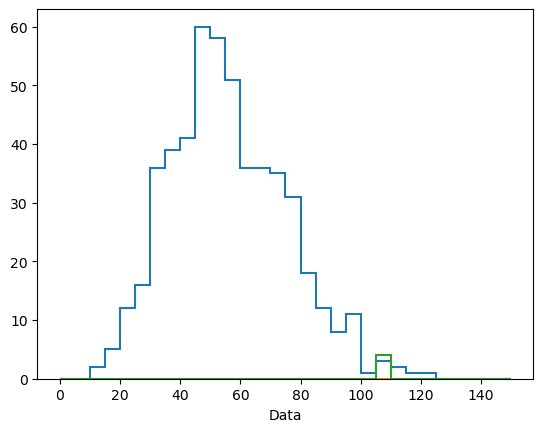

In [21]:
mt_results_local["Data"]["mass"].plot()
#mt_results_local["DYJets"]["mass"].plot()
mt_results_local["WJets"]["mass"].plot()
#mt_results_local["TT"]["mass"].plot()
mt_results_local["VV"]["mass"].plot()

Data_h, Data_bins = mt_results_local["Data"]["mass"].to_numpy()

In [22]:
d = {}
bins = np.linspace(0,150,30)

QCDScaleFactor = 1.6996559936491136

d["Data_h"], d["Data_bins"] = mt_results_local["Data"]["mass"].to_numpy()
d["Data_SS_h"], d["Data_SS_bins"] = mt_results_local["Data"]["ss_mass"].to_numpy()
labels1 = ["DYJets", "WJets", "TT", "VV"]
for i in labels1:
    d[i + "_h"], d[i + "_bins"] =  mt_results_local[i]["mass"].to_numpy()
    d[i + "_SS_h"], d[i + "_SS_bins"] =  mt_results_local[i]["ss_mass"].to_numpy()

d["QCD_h"] = np.subtract(np.subtract(np.subtract(d["Data_SS_h"], d["DYJets_SS_h"], dtype=object, out=None), d["WJets_SS_h"], dtype=object, out=None), d["TT_SS_h"], dtype=object, out=None)
for i in range(d["QCD_h"].size):
    if d["QCD_h"][i] < 0.0:
        d["QCD_h"][i] = 0.0
    d["QCD_w"] = np.full(shape=d["QCD_h"].shape, fill_value=QCDScaleFactor, dtype=np.double)
    d["QCD_hist"] = (d["QCD_h"], d["Data_SS_bins"])


In [23]:
outFile = uproot.recreate("boostedHTT_mt_2018_local.input.root")
outFile["DYJets_met_1_13TeV/data_obs"] = mt_results_local["Data"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/QCD"] = d["QCD_hist"]
outFile["DYJets_met_1_13TeV/WJets"] = mt_results_local["WJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/DYJets125"] = mt_results_local["DYJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/TT"] = mt_results_local["TT"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/VV"] = mt_results_local["VV"]["mass"].to_numpy()
outFile.close()

Now let's do it through condor:







In [8]:
redirector = "root://cmsxrootd.fnal.gov//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
redirector17D = "root://cmsxrootd.fnal.gov//store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"

mt_fileset = {
    "DYJets": [
        redirector+f"/2018/MC/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/231225_151806/0000/NANO_NANO_{i}.root"
        for i in range(1,15)
    ],
    "WJets": [
        redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_{i}.root"
        for i in range(1,15)
    ],
    "TT": [
        redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0000/NANO_NANO_{i}.root"
        for i in range(1,15) 
    ],  
    "VV": [
        redirector+f"/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_{i}.root"
        for i in range(1,15)
    ],
    "Data": [
        redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_{i}.root"
        for i in range(1,5) #fix get real data
    ]
}
inputs = []
for label in mt_fileset:
    input = [get_tree(url) for url in mt_fileset[label]]
    inputs = np.append(inputs, input)
inputs

array([Delayed('get_tree-cd65faf2e8a4f306cff8f3d0c33b4235'),
       Delayed('get_tree-badd31b75c5421715cd6c164589714b0'),
       Delayed('get_tree-bbfb2355d036062f78ff113476e79bae'),
       Delayed('get_tree-4b8e2e2faf6ce783710067d0a3b214f0'),
       Delayed('get_tree-006b5696b04cf1f507f52f04de5e0f13'),
       Delayed('get_tree-8a9a5a584224a2266098ae6d1063d5d0'),
       Delayed('get_tree-5a17e4bffc33f31e86ba45abce3dab42'),
       Delayed('get_tree-300ba6c88650ab7042a0b422aef36e8a'),
       Delayed('get_tree-5819f49b6c4d22cb2b1238ce54bda71b'),
       Delayed('get_tree-eacc5e43b0967bb331e1766379df98bc'),
       Delayed('get_tree-e18dcb03ee35a803dc52e48835b6cb42'),
       Delayed('get_tree-612d72bd133169e9bcb0a3cd127c4e0d'),
       Delayed('get_tree-db00bbf1cc786ac2428b70bc99ba3c01'),
       Delayed('get_tree-d4abd4608671d4ac29224a8d327f4c7a'),
       Delayed('get_tree-dff01d916a205b036722791721d81d77'),
       Delayed('get_tree-fe0ac8fc5d78dc8a6bae0b65df32233b'),
       Delayed('get_tree

In [9]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

In [10]:
PWD = os.getcwd()
print(f'Transferring contents of {PWD} to workers')
INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=8,
    memory="10 GB",
    disk="8 GB",
    death_timeout = '120',
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "+SingularityImage": '"/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask:0.7.22-py3.10-g7cbcc"',
        "Requirements": "HasSingularityJobStart",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path}'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
dask_executor = processor.DaskExecutor(client=client, status=True)
print("Executor created")

client

Transferring contents of /afs/hep.wisc.edu/user/emettner/rootProjects/Radion-DiHiggs-4Tau/NanoRun to workers
Condor logs, output files, error files in /scratch/emettner
Executor created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:3775,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [11]:
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=dask_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 20000 and maxchunks None


In [12]:
print("Calling runner")
mt_results_dask = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Calling runner


RuntimeError: Work item FileMeta(root://cmsxrootd.fnal.gov//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_5.root:Events) caused a KilledWorker exception (likely a segfault or out-of-memory issue)

In [29]:
client.shutdown()

In [20]:
for dset,results, in mt_results_dask.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount'].value}")

NameError: name 'mt_results_dask' is not defined

In [ ]:
outFile = uproot.recreate("boostedHTT_mt_2018.input.root")


